In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.cluster import KMeans
import seaborn as sns

C:\Users\Hacker\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_excel('Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
data = data[data['CustomerID'].notnull()]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [6]:
data['InvoiceDay'] = data['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, x.day))

In [7]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


In [8]:
dt.timedelta(1)

datetime.timedelta(days=1)

In [9]:
pin_date = max(data['InvoiceDay']) + dt.timedelta(1)
pin_date

Timestamp('2011-12-10 00:00:00')

In [10]:
data['TotalSum'] = data['Quantity'] * data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34


In [11]:
rfm = data.groupby('CustomerID').agg({
    'InvoiceDay': lambda x: (pin_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'
})
rfm

,InvoiceDay,InvoiceNo,TotalSum
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,13,176.60


In [12]:
data[data['CustomerID'] == 12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,TotalSum
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,2011-01-18,-77183.6


In [13]:
rfm.rename(columns={
    'InvoiceDay': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)

In [14]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,13,176.60


In [15]:
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
f_labels = range(1, 5)
f_groups = pd.qcut(rfm['Frequency'], q=4, labels=f_labels)
m_labels = range(1, 5)
m_groups = pd.qcut(rfm['Monetary'], q=4, labels=m_labels)

In [16]:
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

In [17]:
rfm

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,326,2,0.00,1,1,1
12347.0,3,182,4310.00,4,4,4
12348.0,76,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,311,17,334.40,1,1,2
...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1
18281.0,181,7,80.82,1,1,1
18282.0,8,13,176.60,4,1,1


In [18]:
X = rfm[['R', 'F', 'M']]
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=400, random_state=0, algorithm='elkan')

In [19]:
kmeans.fit(X)

KMeans(algorithm='elkan', max_iter=400, n_clusters=5, random_state=0)

In [20]:
rfm['kmeans_cluster'] = kmeans.labels_

In [21]:
rfm

,Recency,Frequency,Monetary,R,F,M,kmeans_cluster
CustomerID,,,,,,,
12346.0,326,2,0.00,1,1,1,4
12347.0,3,182,4310.00,4,4,4,2
12348.0,76,31,1797.24,2,2,4,0
12349.0,19,73,1757.55,3,3,4,0
12350.0,311,17,334.40,1,1,2,4
...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,4
18281.0,181,7,80.82,1,1,1,4
18282.0,8,13,176.60,4,1,1,3


In [22]:
rfm[rfm['kmeans_cluster'] == 3].mean()

C:\Users\Hacker\AppData\Local\Temp\ipykernel_4284\2752664996.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rfm[rfm['kmeans_cluster'] == 3].mean()


Recency            22.476945
Frequency          25.230548
Monetary          410.106398
kmeans_cluster      3.000000
dtype: float64

In [23]:
rfm.mean()

C:\Users\Hacker\AppData\Local\Temp\ipykernel_4284\1356782425.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rfm.mean()


Recency             92.581199
Frequency           93.053294
Monetary          1898.459701
kmeans_cluster       1.956313
dtype: float64

In [24]:
kmeans.inertia_

3783.479454523048

<AxesSubplot:>

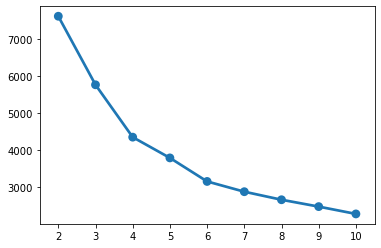

In [25]:
wcss = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=0, algorithm='elkan')
    kmeans.fit(X)
    wcss[k] = kmeans.inertia_
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))

In [26]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=400, random_state=0, algorithm='elkan')
kmeans.fit(X)

KMeans(algorithm='elkan', max_iter=400, n_clusters=6, random_state=0)

In [27]:
kmeans.labels_

array([4, 5, 2, ..., 3, 5, 5])

In [28]:
rfm['kmeans_cluster(6)'] = kmeans.labels_

In [29]:
rfm

,Recency,Frequency,Monetary,R,F,M,kmeans_cluster,kmeans_cluster(6)
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,1,1,4,4
12347.0,3,182,4310.00,4,4,4,2,5
12348.0,76,31,1797.24,2,2,4,0,2
12349.0,19,73,1757.55,3,3,4,0,5
12350.0,311,17,334.40,1,1,2,4,4
...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,4,4
18281.0,181,7,80.82,1,1,1,4,4
18282.0,8,13,176.60,4,1,1,3,3


In [30]:
rfm.drop(columns=['kmeans_cluster'], inplace=True)

In [31]:
rfm

,Recency,Frequency,Monetary,R,F,M,kmeans_cluster(6)
CustomerID,,,,,,,
12346.0,326,2,0.00,1,1,1,4
12347.0,3,182,4310.00,4,4,4,5
12348.0,76,31,1797.24,2,2,4,2
12349.0,19,73,1757.55,3,3,4,5
12350.0,311,17,334.40,1,1,2,4
...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,4
18281.0,181,7,80.82,1,1,1,4
18282.0,8,13,176.60,4,1,1,3


In [32]:
rfm[rfm['kmeans_cluster(6)'] == 5].mean()

C:\Users\Hacker\AppData\Local\Temp\ipykernel_4284\3343221803.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rfm[rfm['kmeans_cluster(6)'] == 5].mean()


Recency                16.002016
Frequency             269.317540
Monetary             5924.245867
kmeans_cluster(6)       5.000000
dtype: float64

In [33]:
rfm.mean()

C:\Users\Hacker\AppData\Local\Temp\ipykernel_4284\1356782425.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rfm.mean()


Recency                92.581199
Frequency              93.053294
Monetary             1898.459701
kmeans_cluster(6)       2.726212
dtype: float64